In [112]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import pickle

In [73]:
df = pd.read_csv("Datasets/training_data.csv")

In [74]:
df.shape

(14304, 18)

In [75]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,7531,Contact Center Representatives,"US, VA, Virginia Beach",NaN,NaN,Tidewater Finance Co. was established in 1992 ...,"Tidewater Finance Company, located in Virginia...",The position requires the following qualificat...,Our company offers a competitive salary plus B...,0,1,0,Full-time,Entry level,Unspecified,Financial Services,Customer Service,0
1,130,Customer Service Associate,"US, TX, Dallas",NaN,NaN,"Novitex Enterprise Solutions, formerly Pitney ...",The Customer Service Associate will be based i...,QualificationsMinimum of 1 year customer servi...,NaN,0,1,0,Full-time,Entry level,High School or equivalent,Telecommunications,Customer Service,0
2,4641,Automated Test Analyst,"NZ, , Auckland",Permanent,NaN,SilverStripe CMS &amp; Framework is an open so...,We are looking for a dedicated and passionate ...,NaN,NaN,0,1,1,Full-time,Mid-Senior level,NaN,Information Technology and Services,NaN,0
3,403,Inside Sales Professional-Omaha,"US, NE, Omaha",NaN,NaN,"ABC Supply Co., Inc. is the nation’s largest w...","As a Sales Representative, you will provide as...","As a Sales Representative, you must have the a...",Your benefits package as a Sales Representativ...,0,1,0,Full-time,NaN,NaN,Building Materials,Sales,0
4,13219,Content Marketing/SEO Manager,"US, CA, Los Angeles",Marketing,NaN,MeUndies is a lifestyle brand that is transfor...,MeUndies is a lifestyle brand that is transfor...,REQUIREMENTS/QUALIFICATIONS/PERSONAL ATTRIBUTE...,"WHY MEUNDIES?We're a fast-growing, VC-backed c...",0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Marketing,0


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14304 entries, 0 to 14303
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               14304 non-null  int64 
 1   title                14304 non-null  object
 2   location             14024 non-null  object
 3   department           5029 non-null   object
 4   salary_range         2283 non-null   object
 5   company_profile      11632 non-null  object
 6   description          14303 non-null  object
 7   requirements         12172 non-null  object
 8   benefits             8501 non-null   object
 9   telecommuting        14304 non-null  int64 
 10  has_company_logo     14304 non-null  int64 
 11  has_questions        14304 non-null  int64 
 12  employment_type      11547 non-null  object
 13  required_experience  8629 non-null   object
 14  required_education   7805 non-null   object
 15  industry             10378 non-null  object
 16  func

In [77]:
new_df=df.drop(columns=['job_id', 'location','department','salary_range', 'telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience','required_education', 'industry', 'function'], axis=1)

In [78]:
new_df.shape

(14304, 6)

In [79]:
new_df.head()

,title,company_profile,description,requirements,benefits,fraudulent
0,Contact Center Representatives,Tidewater Finance Co. was established in 1992 ...,"Tidewater Finance Company, located in Virginia...",The position requires the following qualificat...,Our company offers a competitive salary plus B...,0
1,Customer Service Associate,"Novitex Enterprise Solutions, formerly Pitney ...",The Customer Service Associate will be based i...,QualificationsMinimum of 1 year customer servi...,NaN,0
2,Automated Test Analyst,SilverStripe CMS &amp; Framework is an open so...,We are looking for a dedicated and passionate ...,NaN,NaN,0
3,Inside Sales Professional-Omaha,"ABC Supply Co., Inc. is the nation’s largest w...","As a Sales Representative, you will provide as...","As a Sales Representative, you must have the a...",Your benefits package as a Sales Representativ...,0
4,Content Marketing/SEO Manager,MeUndies is a lifestyle brand that is transfor...,MeUndies is a lifestyle brand that is transfor...,REQUIREMENTS/QUALIFICATIONS/PERSONAL ATTRIBUTE...,"WHY MEUNDIES?We're a fast-growing, VC-backed c...",0


In [80]:
new_df.isnull().sum()

title                 0
company_profile    2672
description           1
requirements       2132
benefits           5803
fraudulent            0
dtype: int64

In [81]:
new_df["company_profile"].fillna(new_df["company_profile"].mode()[0], inplace=True)
new_df["description"].fillna(new_df["description"].mode()[0], inplace=True)
new_df["requirements"].fillna(new_df["requirements"].mode()[0], inplace=True)
new_df["benefits"].fillna(new_df["benefits"].mode()[0], inplace=True)

C:\Users\perug\AppData\Local\Temp\ipykernel_29128\1198365526.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  new_df["company_profile"].fillna(new_df["company_profile"].mode()[0], inplace=True)
C:\Users\perug\AppData\Local\Temp\ipykernel_29128\1198365526.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values

In [82]:
new_df.isnull().sum()

title              0
company_profile    0
description        0
requirements       0
benefits           0
fraudulent         0
dtype: int64

In [83]:
new_df.groupby("fraudulent")["fraudulent"].count()

fraudulent
0    13611
1      693
Name: fraudulent, dtype: int64

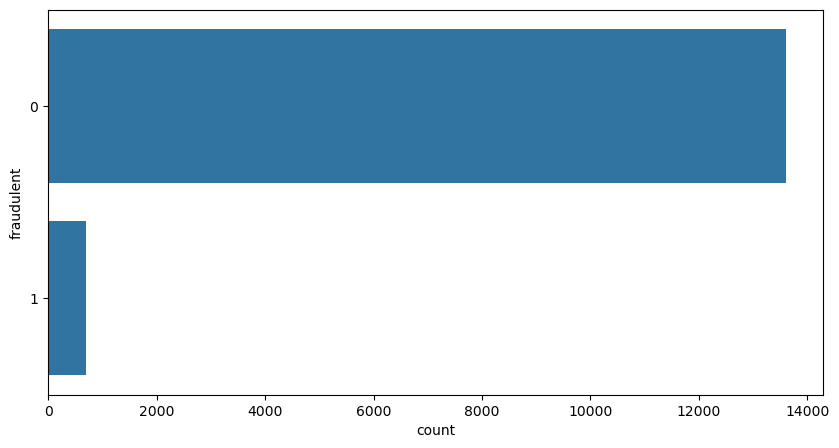

In [84]:
plt.figure(figsize = (10,5))
sns.countplot(y = 'fraudulent', data = new_df)
plt.show()

In [85]:
new_df["fraudulent"].value_counts(normalize=True)

fraudulent
0    0.951552
1    0.048448
Name: proportion, dtype: float64

In [86]:
fraudulent_rows = new_df[new_df['fraudulent'] == 0]
rows_to_drop = fraudulent_rows.sample(n=12940, random_state=20)
df_reduced = new_df.drop(rows_to_drop.index)

In [87]:
df_reduced.shape

(1364, 6)

In [88]:
df_reduced["fraudulent"].value_counts(normalize=True)

fraudulent
1    0.508065
0    0.491935
Name: proportion, dtype: float64

In [89]:
df_reduced.head()

,title,company_profile,description,requirements,benefits,fraudulent
2,Automated Test Analyst,SilverStripe CMS &amp; Framework is an open so...,We are looking for a dedicated and passionate ...,University degree required. TEFL / TESOL / CEL...,See job description,0
26,Customer Service Rep,We help teachers get safe &amp; secure jobs ab...,We are seeking a Customer Service Representati...,University degree required. TEFL / TESOL / CEL...,See job description,1
39,"Agency Sales Managers $150-$175,000/yr",We have aggressive growth plans in place for t...,We provide No Credit Check Financing to custom...,Experience and Skills Required- Minimum of 3 ...,We Provide- Complete online training and offic...,1
45,Regional Sales Director - West,WebLinc is the e-commerce platform and service...,WebLinc is looking for a Regional Sales Direct...,"Minimum of 10 years experience in sales, at le...",Health &amp; WellnessMedical planPrescription ...,0
53,Sound Designer,"Our team is made of designers, physics wizards...",Conjure sonic worlds.We’re seeking a sound des...,You have:A deep knowledge of sound design theo...,"Tinybop offers competitive salaries, comprehen...",0


In [90]:
df_reduced.isnull().sum()

title              0
company_profile    0
description        0
requirements       0
benefits           0
fraudulent         0
dtype: int64

In [91]:
df_reduced['merged_data'] = df_reduced["title"]+" "+df_reduced["company_profile"]+" "+df_reduced['description']+" "+df_reduced["requirements"]+df_reduced["benefits"]

In [92]:
df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1364 entries, 2 to 14298
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            1364 non-null   object
 1   company_profile  1364 non-null   object
 2   description      1364 non-null   object
 3   requirements     1364 non-null   object
 4   benefits         1364 non-null   object
 5   fraudulent       1364 non-null   int64 
 6   merged_data      1364 non-null   object
dtypes: int64(1), object(6)
memory usage: 85.2+ KB


In [93]:
print(df_reduced["merged_data"])

2        Automated Test Analyst SilverStripe CMS &amp; ...
26       Customer Service Rep We help teachers get safe...
39       Agency Sales Managers $150-$175,000/yr We have...
45       Regional Sales Director - West WebLinc is the ...
53       Sound Designer  Our team is made of designers,...
                               ...                        
14261    CASH Pay Jobs (Part Time Staff Wanted) We help...
14269    Office Administrator Replise was started in 20...
14276    Electrical Controls Engineer We Provide Full T...
14279    Accounts Receivable Specialist Aptitude Staffi...
14298    Strategic Account Director - New York We build...
Name: merged_data, Length: 1364, dtype: object


In [94]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
print(stop_words)

{'don', 'our', "hasn't", 'with', 'isn', 'herself', 'until', 'do', 'we', 'himself', 'o', 'your', "won't", 'each', 'from', "i'm", 's', 'such', "mightn't", 'him', 'before', 'shan', 'during', 'doing', 'wasn', "they've", 'as', 'on', "you'd", 'aren', 'won', 'is', "should've", 'couldn', 'than', 'been', 'off', 'and', 'being', 'at', 'can', "they'll", 'did', "you're", 'was', 'd', 'own', 'above', "wouldn't", 'most', "weren't", "doesn't", 'he', 'by', 'other', 'too', 'further', "hadn't", 'have', 'why', 'up', 'be', "couldn't", 'to', "they're", 'under', "aren't", 'ma', 'same', 'will', 'my', 'needn', 've', 'here', 'mightn', "i've", 'only', "they'd", 'myself', 'again', 'against', 'more', "mustn't", 'mustn', 'm', 'hadn', 'wouldn', "he'd", 'so', 'or', 'where', 'what', 'should', 'both', 'between', 'this', 'yourself', "isn't", 'haven', 'hers', 'having', "it'd", 'a', 't', 'were', 'yours', 'just', 'few', "you've", 'out', 'i', 'itself', 'after', "i'll", 'these', "she's", 'those', 'who', 'y', 'because', 'they'

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\perug\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [95]:
port_stem = PorterStemmer()

In [96]:
def preprocess_text(text):
    return re.sub(r'[^a-zA-Z]', " ", text).lower()

In [97]:
def stemming(content):
        words = content.split()  # Tokenize words
        return " ".join([port_stem.stem(word) for word in words if word not in stop_words])

In [98]:
tqdm.pandas()

In [129]:
df_reduced['merged_data'] = df_reduced['merged_data'].progress_apply(lambda x:stemming(preprocess_text(x)))

100%|██████████| 1364/1364 [00:04<00:00, 324.78it/s]


In [130]:
X = df_reduced['merged_data'].values
Y = df_reduced['fraudulent'].values

In [131]:
# X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, stratify=Y, random_state=4)

In [134]:
vectorizer = TfidfVectorizer()
X_train_transformed = vectorizer.fit_transform(X)
# X_test_transformed = vectorizer.transform(X_test)

In [135]:
model = LogisticRegression()
model.fit(X_train_transformed, Y)

LogisticRegression()

In [ ]:
# X_train_prediction = model.predict(X_train_transformed)
# training_data_accuracy = accuracy_score(X_train_prediction, Y_train)
# print("Training Accuracy = ", training_data_accuracy)

In [ ]:
# X_test_prediction = model.predict(X_test_transformed)
# test_data_accuracy = accuracy_score(X_test_prediction, Y_test)
# print("Test accuracy = ", test_data_accuracy)

In [ ]:
# y_pred = model.predict(X_test_transformed)
# f1 = f1_score(Y_test, y_pred)
# print("Validation F1 Score: ", f1)

In [ ]:
# print("Classification report: ", classification_report(Y_test, X_test_prediction))  

In [136]:
with open("models/tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

In [137]:
with open("models/model.pkl", "wb") as f:
    pickle.dump(model, f)